Modelo GARCH (1,1) para estimar a volatilidade de PETR4

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      6,   Neg. LLF: 320338520.4304412
Iteration:      2,   Func. Count:     18,   Neg. LLF: 283689234603327.75
Iteration:      3,   Func. Count:     30,   Neg. LLF: 9951.705233746994
Iteration:      4,   Func. Count:     39,   Neg. LLF: 2590446900.6953597
Iteration:      5,   Func. Count:     51,   Neg. LLF: 12890323.258733256
Iteration:      6,   Func. Count:     63,   Neg. LLF: 476276.391580997
Iteration:      7,   Func. Count:     75,   Neg. LLF: 3465774.489471818
Iteration:      8,   Func. Count:     86,   Neg. LLF: -5358.809417932749
Optimization terminated successfully    (Exit mode 0)
            Current function value: -5358.809417891737
            Iterations: 12
            Function evaluations: 86
            Gradient evaluations: 8
MAE: 0.033185844129602064
MSE: 0.002015391112819547
RMSE: 0.04489310763156798


C:\Users\Marco Antonio\anaconda3\lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0009907. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


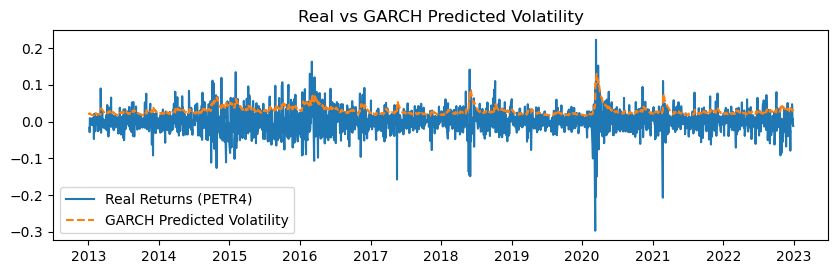

In [5]:
import numpy as np
import pandas as pd
import yfinance as yf
from arch import arch_model
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Baixar dados da Petrobras (PETR4)
petrobras = yf.download('PETR4.SA', start='2013-01-01', end='2023-01-01')

# Calcular retornos diários
returns = petrobras['Adj Close'].pct_change().dropna()

# Ajustar um modelo GARCH(1,1)
model_garch = arch_model(returns, vol='Garch', p=1, q=1)
results_garch = model_garch.fit()

# Obter as previsões da volatilidade condicional
predicted_volatility = results_garch.conditional_volatility

# Calcular os retornos previstos com base na volatilidade condicional
predicted_returns = predicted_volatility * np.random.normal(0, 1, len(returns))

# Remover os NaNs resultantes das operações
predicted_returns = predicted_returns.dropna()

# Corrigir os índices para garantir que ambos tenham o mesmo comprimento
returns = returns[1:]
predicted_returns = predicted_returns[:len(returns)]  # Ajuste aqui para garantir o mesmo comprimento

#Plotagem dos gráficos (Retorno x volatilidade estimada)

plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(returns.index[1:], returns[1:], label='Real Returns (PETR4)')
plt.plot(predicted_volatility.index, predicted_volatility, label='GARCH Predicted Volatility', linestyle='dashed')
plt.title('Real vs GARCH Predicted Volatility')
plt.legend()

# Calcular métricas de avaliação
mae = mean_absolute_error(returns, predicted_returns)
mse = mean_squared_error(returns, predicted_returns)
rmse = np.sqrt(mse)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

Estimação da volatilidade via LSTM


In [7]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Baixe os dados históricos
symbol = 'PETR4.SA'
start_date = '2013-01-01'
end_date = '2023-01-01'
data = yf.download(symbol, start=start_date, end=end_date)

# Use apenas os preços de fechamento ajustados
prices = data['Adj Close']

# Calcule os retornos diários
returns = prices.pct_change().dropna()

# Preparação dos dados
scaler = MinMaxScaler(feature_range=(0, 1))
returns_scaled = scaler.fit_transform(returns.values.reshape(-1, 1))

# Divisão dos dados em treino e teste
train_size = int(len(returns_scaled) * 0.8)
train_data = returns_scaled[:train_size]
test_data = returns_scaled[train_size:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        X.append(dataset[i:(i + look_back), 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 30
X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

# Reshape dos dados para LSTM [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Construção do modelo LSTM
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Treinamento do modelo
model.fit(X_train, Y_train, epochs=50, batch_size=32, verbose=1)

# Previsões
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Invertendo a escala de previsão
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

# Cálculo da volatilidade (desvio padrão dos retornos previstos)
train_volatility = np.std(train_predict - Y_train)
test_volatility = np.std(test_predict - Y_test)

print(f"Volatilidade de treino: {train_volatility}")
print(f"Volatilidade de teste: {test_volatility}")

# Cálculo dos erros
train_mae = mean_absolute_error(Y_train[0], train_predict[:, 0])
test_mae = mean_absolute_error(Y_test[0], test_predict[:, 0])

train_mse = mean_squared_error(Y_train[0], train_predict[:, 0])
test_mse = mean_squared_error(Y_test[0], test_predict[:, 0])

train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

print(f"MAE de treino: {train_mae}")
print(f"MAE de teste: {test_mae}")
print(f"MSE de treino: {train_mse}")
print(f"MSE de teste: {test_mse}")
print(f"RMSE de treino: {train_rmse}")
print(f"RMSE de teste: {test_rmse}")

# Plotando a estimação da volatilidade
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.title('Volatilidade de Treino')
plt.plot(train_predict - Y_train[0], label='Resíduos')
plt.axhline(y=train_volatility, color='r', linestyle='--', label='Volatilidade Estimada')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Volatilidade de Teste')
plt.plot(test_predict - Y_test[0], label='Resíduos')
plt.axhline(y=test_volatility, color='r', linestyle='--', label='Volatilidade Estimada')
plt.legend()

plt.show()

[*********************100%***********************]  1 of 1 completed
Epoch 1/50
62/62 [==============================] - 4s 5ms/step - loss: 0.0416
Epoch 2/50
62/62 [==============================] - 0s 4ms/step - loss: 0.0042
Epoch 3/50
62/62 [==============================] - 0s 5ms/step - loss: 0.0042
Epoch 4/50
62/62 [==============================] - 0s 4ms/step - loss: 0.0042
Epoch 5/50
62/62 [==============================] - 0s 4ms/step - loss: 0.0042
Epoch 6/50
62/62 [==============================] - 0s 4ms/step - loss: 0.0042
Epoch 7/50
62/62 [==============================] - 0s 5ms/step - loss: 0.0041
Epoch 8/50
62/62 [==============================] - 0s 4ms/step - loss: 0.0042
Epoch 9/50
62/62 [==============================] - 0s 4ms/step - loss: 0.0041
Epoch 10/50
62/62 [==============================] - 0s 3ms/step - loss: 0.0042
Epoch 11/50
62/62 [==============================] - 0s 4ms/step - loss: 0.0041
Epoch 12/50
62/62 [==============================] - 0s 3ms/

C:\Users\Marco Antonio\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


**GARCH:**

MAE: 0.033185844129602064

MSE: 0.002015391112819547

RMSE: 0.04489310763156798



**LSTM:**

MAE de treino: 0.026564150514071214

MAE de teste: 0.024304460006705848


MSE de treino: 0.0013132878297553582

MSE de teste: 0.0009965990556269572


RMSE de treino: 0.03623931331793358

RMSE de teste: 0.03156895715140044